In [41]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
import pandas as pd
import data 

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
# df = pd.merge(features, outcomes, on='id', how='left')

100%|██████████| 49/49 [00:01<00:00, 37.01it/s]
31it [00:01, 16.49it/s]

final shape (12044, 243)


# make full data matrix

In [43]:
'''Get preprocessed features from df
'''
def remove_zero_cols(df):
    return df.loc[:, (df != 0).any(axis=0)] # remove any col that is all 0s

print(df.shape)
df_filt = features.dropna(axis=1, thresh=NUM_PATIENTS - 602) # thresh is how many non-nan values - 602 is 5%
print(df_filt.shape)
print(list(df_filt.keys()))
# originally used features: age < 2, severe mechanism of injury (includes many things), vomiting, hypotension, GCS
# thoracic tenderness, evidence of thoracic wall trauma
# costal marign tenderness, decreased breath sounds, abdominal distention
# complaints of abdominal pain, abdominal tenderness (3 levels)
# evidence of abdominal wall trauma or seat belt sign
# distracting patinful injury
# femur fracture

# delete some columns
keys = list(df_filt.keys())
keys_to_remove = [k for k in keys if 'Repeat_instance' in k]
df_filt = df_filt.drop(labels=keys_to_remove, axis=1)
print('keys removed', keys_to_remove, 'new shape', df_filt.shape)

# pandas impute missing values with median
df_filt = df_filt.fillna(df_filt.median())
df_filt = remove_zero_cols(df_filt)

ks_categorical = ['SEX', 'RACE', 'HISPANIC_ETHNICITY']
for k in ks_categorical:
    df_filt[k] = df_filt[k].astype(str)
# keys = ['SEX', 'RACE', 'ageinyrs']
keys = list(df_filt.keys())
# print(df_filt.dtypes)
X_feats = pd.get_dummies(df_filt[keys], dummy_na=True) # treat na as a separate category
X_feats = remove_zero_cols(X_feats)

(12044, 245)
(12044, 62)
['id', 'SEX', 'RACE', 'HISPANIC_ETHNICITY', 'ageinyrs', 'EDTriageDay_1', 'EDTriageTime_1', 'InjuryDay_1', 'InjTmKnown_1', 'TriageTmUnkown_1', 'Certification_1', 'ThoracicTrauma_1', 'ThoracicTender_1', 'LtCostalTender_1', 'RtCostalTender_1', 'DecrBreathSound_1', 'AbnChestAusc_1', 'FlankTender_1', 'PelvicTender_1', 'PelvisUnstable_1', 'NonAbdSurgery_1', 'CurrIntubated_1', 'PharmaParalyzed_1', 'PharmaSedated_1', 'AlcDrgSuspicion_1', 'GCSEye_1', 'GCSVerbal_1', 'GCSMotor_1', 'GCSScore_1', 'Preverbal_1', 'AbdomenPain_1', 'VomitWretch_1', 'ShortBreath_1', 'DistractingPain_1', 'InjuryMechanism_1', 'RecodedMOI_1', 'AbdUltrasound_1', 'AbdCTScan_1', 'PtHosp_1', 'AbdTrauma_1', 'SeatBeltSign_1', 'AbdDistention_1', 'BowelSounds_1', 'AbdomenTender_1', 'PeritonIrrit_1', 'RectalBlood_1', 'InitSysBP_1', 'InitSysBPRange_1', 'InitResp_1', 'InitRespRange_1', 'HRDocumented_1', 'InitHeartRate_1', 'IAISuspicion_1', 'IAIAcuteInterv_1', 'LabResultAware_1', 'RefuseFU_1', 'ChestCXR_4a', '

In [44]:
X_feats.keys()

Index(['id', 'ageinyrs', 'EDTriageTime_1', 'InjuryDay_1', 'InjTmKnown_1',
       'TriageTmUnkown_1', 'Certification_1', 'ThoracicTrauma_1',
       'ThoracicTender_1', 'LtCostalTender_1', 'RtCostalTender_1',
       'DecrBreathSound_1', 'AbnChestAusc_1', 'FlankTender_1',
       'PelvicTender_1', 'PelvisUnstable_1', 'NonAbdSurgery_1',
       'CurrIntubated_1', 'PharmaParalyzed_1', 'PharmaSedated_1',
       'AlcDrgSuspicion_1', 'GCSEye_1', 'GCSVerbal_1', 'GCSMotor_1',
       'GCSScore_1', 'Preverbal_1', 'AbdomenPain_1', 'VomitWretch_1',
       'ShortBreath_1', 'DistractingPain_1', 'InjuryMechanism_1',
       'RecodedMOI_1', 'AbdUltrasound_1', 'AbdCTScan_1', 'PtHosp_1',
       'AbdTrauma_1', 'SeatBeltSign_1', 'AbdDistention_1', 'BowelSounds_1',
       'AbdomenTender_1', 'PeritonIrrit_1', 'RectalBlood_1', 'InitSysBP_1',
       'InitSysBPRange_1', 'InitResp_1', 'InitRespRange_1', 'HRDocumented_1',
       'InitHeartRate_1', 'IAISuspicion_1', 'IAIAcuteInterv_1',
       'LabResultAware_1', 'Refu

In [45]:
X_np = X_feats.values
feature_names = list(X_feats)
y_np = outcomes['iai_intervention']

In [ ]:
# X_feats.describe()

# prediction

In [47]:
max_depth = 3
m = DecisionTreeClassifier(max_depth=max_depth, class_weight={0: 1, 1: 1})
m_cv = cross_validate(m, X_np, y_np, cv=5, return_train_score=True, return_estimator=True)

In [48]:
m_cv['test_score']

array([0.98257261, 0.98215027, 0.98298049, 0.9833887 , 0.9833887 ])

In [49]:
np.mean(m_cv['train_score'])

0.9836640684443154

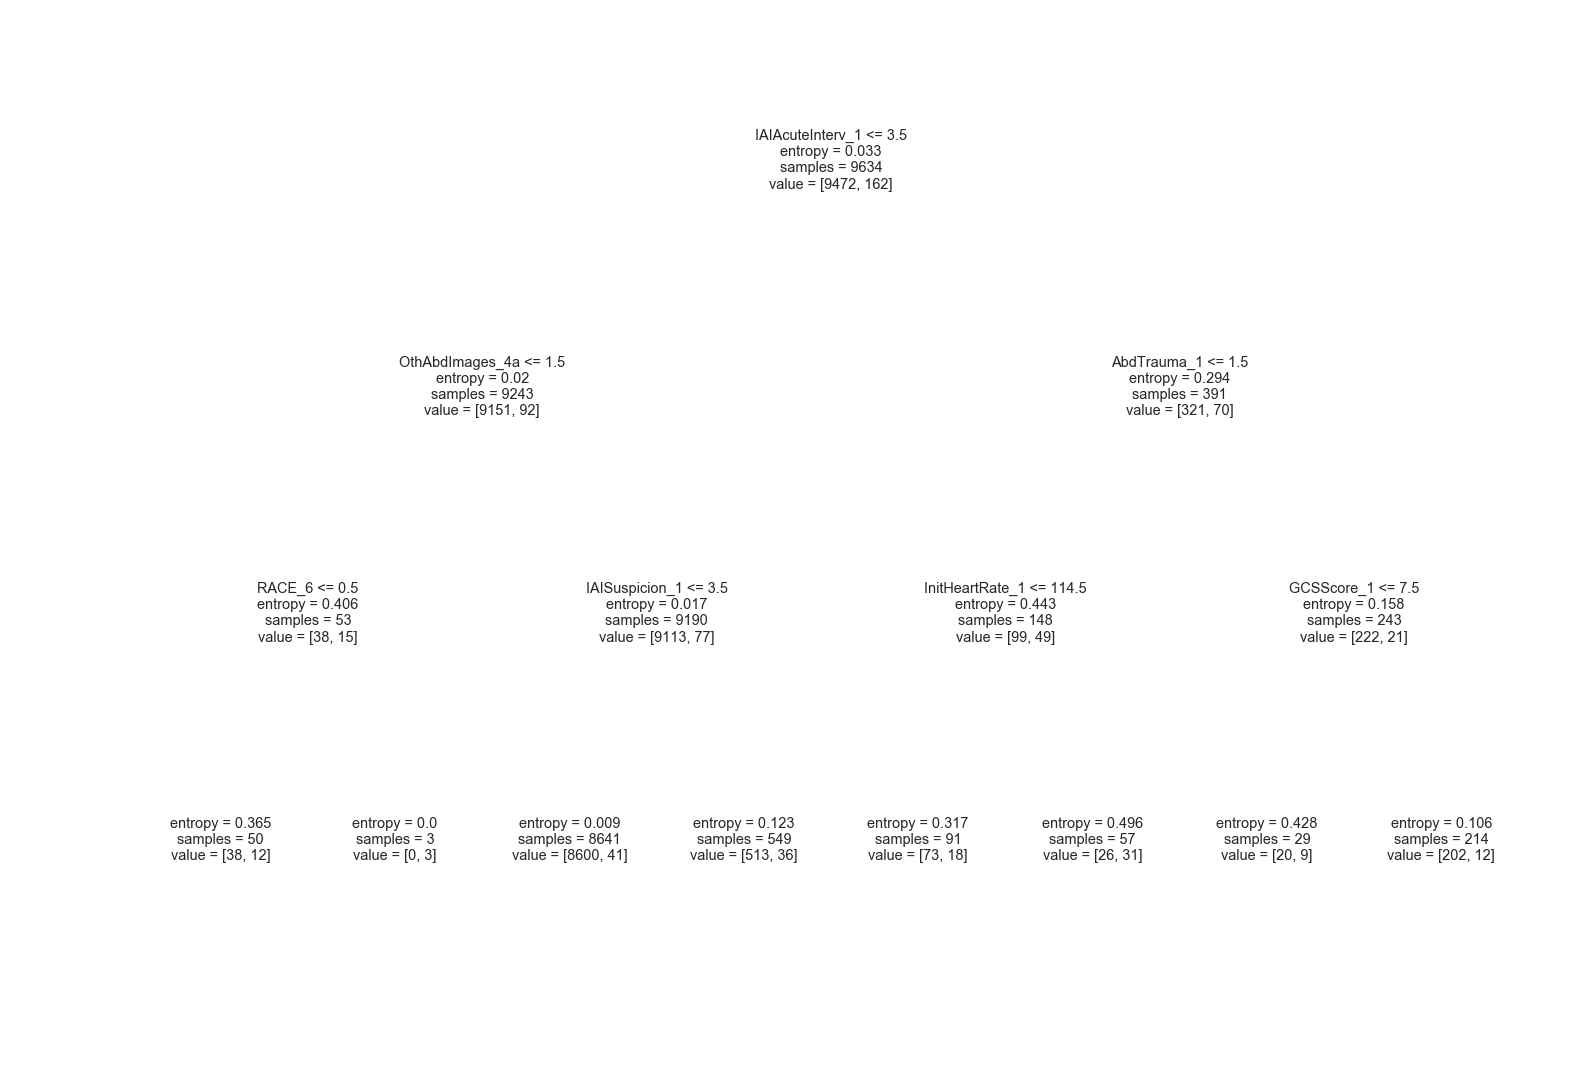

In [50]:
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=feature_names)
plt.show()

In [ ]:
# IAISuspicion_1 - Clinical suspicion for the presence of IAI identified on CT (split into 5 levels)
# IAIAcuteInterv_1 - Clinical suspicion for IAI in need of acute intervention (split into 5 levels)